In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [535]:
# env variables - need to be created already or passed as args
# test_profile = np.array([1,2,5,10,11,12,13])
launch_pers = 6
terminal = len(test_profile)
coh_growth = 0.1
term_growth = -0.

def debug_out(spend_per):
    start = max(0,spend_per - launch_pers)
    width = 50
    print("launch period duration (no. of periodic cohorts)".ljust(width), launch_pers)
    print("profile length (to terminal)".ljust(width), terminal)
    print("spend period requested ".ljust(width), spend_per)
#     print("oldest active cohort (first is zero)".ljust(width), max(0,spend_per - terminal))
#     print("newest active cohort (first is zero)".ljust(width), min(launch_pers, spend_per)-1) # -1 to make zero based
    actives = max(0,min(launch_pers,spend_per,terminal)-max(0,spend_per-terminal))
    print("number active cohorts ".ljust(width), actives)
    print("slice start at profile period / value".ljust(width), start, "/", test_profile[min(start,terminal-1)])
    print("start to terminal".ljust(width), test_profile[start:min(spend_per, terminal)])
    print("number of terminal periods".ljust(width), max(0,spend_per - terminal))
    print("cohort growth ".ljust(width), coh_growth)
    print("terminal growth ".ljust(width), term_growth)
    print("")

In [569]:
test_profile = np.array([1,2,5,10,11,12,1])
term_value = test_profile[-1]*1
launch_pers = 5

def spender(spend_per, debug=True):
    if debug: debug_out(spend_per)
    frame=(max(0, spend_per - launch_pers), spend_per)
    f_start, f_end = frame
    if debug: print("frame ", frame)
    for prof_point in range(f_start, f_end):
        coh_id = min(launch_pers, spend_per)-(prof_point-f_start) - 1
        if debug: 
            print("prof point ", prof_point, "coh id ", coh_id, end= " ")
        if prof_point < len(test_profile):
            if debug: 
                print("value ", test_profile[prof_point], "coh mult",((1+coh_growth)**coh_id))
            yield test_profile[prof_point]  * ((1+coh_growth)**coh_id) 
        else:
            term_out = term_value  * ((1+coh_growth)**coh_id) * ((1+term_growth)**(prof_point - len(test_profile)+1))
            if debug: print("value ", term_value, "term mult",((1+coh_growth)**coh_id) * ((1+term_growth)**(prof_point - len(test_profile)+1)))
            yield term_out

list(spender(12))
# for x in range(20):
#     print(sum(spender(x, debug=False)))

launch period duration (no. of periodic cohorts)   5
profile length (to terminal)                       5
spend period requested                             12
number active cohorts                              0
slice start at profile period / value              7 / 11
start to terminal                                  []
number of terminal periods                         7
cohort growth                                      0
terminal growth                                    -0.0

frame  (7, 12)
prof point  7 coh id  4 value  1 term mult 1.0
prof point  8 coh id  3 value  1 term mult 1.0
prof point  9 coh id  2 value  1 term mult 1.0
prof point  10 coh id  1 value  1 term mult 1.0
prof point  11 coh id  0 value  1 term mult 1.0


[1.0, 1.0, 1.0, 1.0, 1.0]

[0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0999999999999996, 5.3099999999999996, 5.6410000000000009, 6.1051000000000011, 6.7156100000000016, 7.3871710000000022, 8.1258881000000027, 8.9384769100000057, 9.8323246010000069, 10.815557061100009, 11.897112767210009, 13.08682404393101]


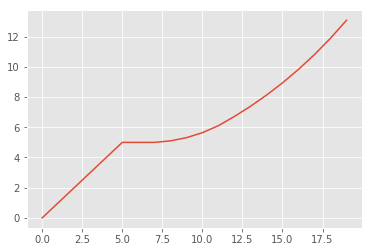

In [429]:
out_list = []
for i in range(20):
    out_list.append(sum(spender(i, debug=False)))
print(out_list)
plt.plot(out_list)

In [571]:
class SpendObject:
    '''Defines a body of spending based on a period of launches (cohorts), each based on a fundamental profile and cohort growth
    (i.e. change in magnitude of profile over successive cohorts).
    The period for calculating spend is open:  the last period in the profile is taken to be the "terminal" spend,
    which changes according to the terminal growth rate (this would normally be negative).
    '''
    def __init__(self, profile, launch_pers, coh_growth=0, term_growth=0):
        self.profile = profile
        self.launch_pers = launch_pers
        self.prof_len = len(profile)
        self.coh_growth = coh_growth
        self.term_growth = term_growth
        self.term_value = profile[-1]
        width = 40
        self.info = {"launch periods": self.launch_pers,
                     "profile length": len(self.profile)}
    
#     self.info = "W" # ("\n".join("".join("launch periods: ", str(launch_pers).ljust(width)),
#                              "".join("profile length: ", str(len(profile)).ljust(width)))

    # Takes a point in time (eg a year or other period), and calculates spend in that period on all cohorts
    # (i.e. launches from a given period eg year)   
    
#     def spender(spend_per, debug=True):
#         if debug: debug_out(spend_per)
#         frame=(max(0, spend_per - launch_pers), spend_per)
#         f_start, f_end = frame
#         if debug: print("frame ", frame)
#         for prof_point in range(f_start, f_end):
#             coh_id = min(launch_pers, spend_per)-(prof_point-f_start) - 1
#             if debug: 
#                 print("prof point ", prof_point, "coh id ", coh_id, end= " ")
#             if prof_point < len(test_profile):
#                 if debug: 
#                     print("value ", test_profile[prof_point], "coh mult",((1+coh_growth)**coh_id))
#                 yield test_profile[prof_point]  * ((1+coh_growth)**coh_id) 
#             else:
#                 term_out = term_value  * ((1+coh_growth)**coh_id) * ((1+term_growth)**(prof_point - len(test_profile)+1))
#                 if debug: print("value ", term_value, "term mult",((1+coh_growth)**coh_id) * ((1+term_growth)**(prof_point - len(test_profile)+1)))
#                 yield term_out

            
    def _spender(self, spend_per, debug=False):
        if debug: debug_out(spend_per)

        # Conceptually define a frame going backwards from the spend period for the number of periods of launches
        # - that is, encompassing the spend in that period for each of the launch cohorts.
        # Ignoring growth, the components of this frame will be the same as if the frame is applied
        # to the underlying profile.  That is, for a spend period of n, spend in the zeroth cohort will be the 
        # nth point in the profile. Spend in period n on products in the 1st cohort will be the (n-1)th point in the profile.
        # Iterate through the frame as applied to the profile.  So the zeroth element in the frame will be the 
        # profile spend corresponding to the spend period minus the number of launch periods (the length of the frame).  
        # The last period in the frame will be the profile spend corresponding to the spend period. 
        
        # First, define the frame by going back from the spend period by the number of launch periods
        frame = (max(0, spend_per - launch_pers), spend_per)   
        f_start, f_end = frame
        # Now iterate through the frame (i.e. through the cohorts), yielding the spend at the corresponding profile point,
        # adjusted as necessary.  If the profile point is beyond the terminal, then calculate appropriately
        for prof_point in range(f_start, f_end):
            # It helps to know which cohort we're on.  The last period in the frame corresponds to the zeroth cohort.
            # So the first will correspond to the last launch period (minus 1 to make start at zero).  
            # Then iterate through with the index
            coh_id = min(self.launch_pers, spend_per)-(prof_point-f_start) - 1
            if debug: print("coh_id ", coh_id)
            
            # As long as the period is within the profile, yield the corresponding profile point
            if prof_point < self.prof_len:
                # adjust for cohort growth
                yield self.profile[prof_point] * ((1+self.coh_growth)** coh_id)
            
            # If the period is beyond the profile, use the terminal value
            else:
                # adjust the terminal value by the cohort growth, then acc to the number of periods post terminal
                yield self.term_value \
                        * ((1+self.coh_growth)**coh_id) \
                        * ((1+self.term_growth)**(prof_point - self.prof_len+1))
                
    def point_spend(self, spend_per):
        return sum(self._spender(spend_per))
    
    def __getitem__(self, sl):
        # test if it's a single index, rather than a slice
        if isinstance(sl,int):
            return sum(self._spender(sl))
        else:
            slice_out = []
            for i in range(sl.start, sl.stop):
                slice_out.append(sum(self._spender(i)))
            return slice_out
    
    def get_np(self, max_per, debug=False):
        np_out_list = []
        for i, per in enumerate(range(max_per)):
            np_out_list.append(sum(self._spender(per, debug)))
        return(np.array(np_out_list))
    

coh0 = SpendObject(test_profile, 5, 0.1, -0.1)
coh0.info

{'launch periods': 6, 'profile length': 7}

In [578]:
new_coh = SpendObject(test_profile, 5, 0.1, -0.1)

new_coh.get_np(20)

array([  0.        ,   1.        ,   3.1       ,   8.41      ,
        19.251     ,  32.1761    ,  45.7832    ,  48.1405    ,
        45.802     ,  35.0871    ,  21.6092    ,   5.1001    ,
         4.59009   ,   4.131081  ,   3.7179729 ,   3.34617561,
         3.01155805,   2.71040224,   2.43936202,   2.19542582])

In [367]:
coh1.coh_growth

0.1

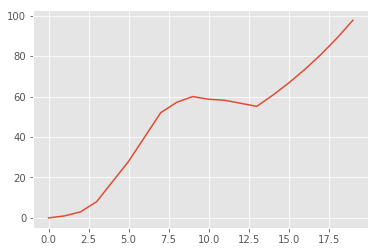

In [363]:
plt.plot(coh0.get_np(20))

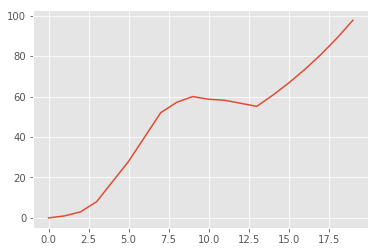

In [364]:
plt.plot(coh1.get_np(20))

In [347]:
coh.get_np(20)

array([  0.        ,   1.        ,   3.        ,   8.        ,
        18.        ,  28.        ,  40.        ,  52.        ,
        57.15      ,  60.015     ,  58.6665    ,  58.18315   ,
        56.651465  ,  55.1666115 ,  60.68327265,  66.75159992,
        73.42675991,  80.7694359 ,  88.84637949,  97.73101744])

In [159]:
coh[5:10]

slice(5, 10, None)


[29, 41, 53, 57.5, 59.0]

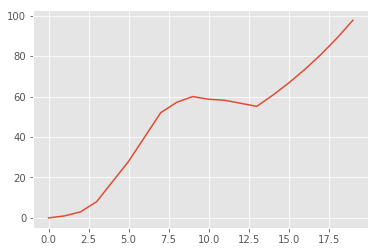

In [348]:
out_list1 = []
for x in range(20):
    out_list1.append(coh.point_spend(x))
plt.plot(out_list1)

In [349]:
launches_list = list(range(5, 10, 1))
objs_out = []
for launch in launches_list:
    cohx = SpendObject(test_profile, launch)
    objs_out.append(cohx)
    

In [350]:
nps_out = []
for obj in objs_out:
    nps_out.append(obj.get_np(20))


In [351]:
len(nps_out)

5

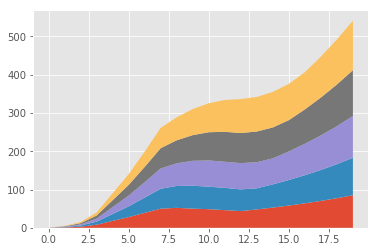

In [352]:
plt.style.use('ggplot')
plt.stackplot(range(0,20),nps_out)

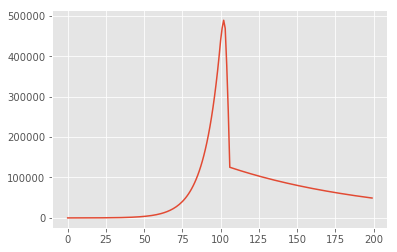

In [444]:
coh = SpendObject(test_profile, 100, 0.1, -0.01)
plt.plot(coh.get_np(200))
